In [11]:
import sys
sys.path.append("..")

import os 
import cv2
import torch
import torchvision
import torch.functional as F
import numpy as np

from osgeo import gdal
from PIL import Image

from config import default_config, update_config
from Module.seg_hrnet import HighResolutionNet

from dataset.datasets import read_tiff, preprocess

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from collections import OrderedDict

In [12]:
# 获取所有层的名称
def get_all_layers(model, prefix=''):
    all_layers = OrderedDict()
    for name, layer in model.named_children():
        full_name = prefix + '.' + name if prefix else name
        if isinstance(layer, torch.nn.Module):
            all_layers[full_name] = layer
            all_layers.update(get_all_layers(layer, full_name))
        else:
            all_layers[full_name] = layer
    return all_layers



class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        seg_out = self.model(x)
        return seg_out

In [13]:
# --------------------------------------------------------------------------------------------
# 实现语义分割模型某个层的可视化
# --------------------------------------------------------------------------------------------

folder_names = ["422", 
                "768", 
                "1851",
                "2689", 
                ]

atten_names = [ "hrnet",
                "cbam",
                "se",
                "newsp"
            ]

best_model_paths=[

    r"../checkpoints_seg_hrnet_BS_4_EPOCHS_100_time_2023-12-13_09_37_58/CP_epoch40.pth",
    r"../checkpoints_seg_cbam_hrnet_BS_4_EPOCHS_100_time_2023-12-12_17_58_28/CP_epoch40.pth",
    r"../checkpointsseg_se_hrnet_BS_4_EPOCHS_100_time_2023-12-12_17_21_01/CP_epoch40.pth",
    r"../checkpoints_seg_newsp_hrnet_BS_4_EPOCHS_100_time_2023-12-14_11_24_27/best_model.pth"

]
cfg_file_names = [

    "seg_hrnet.yaml",
    "seg_cbam_hrnet.yaml",
    "seg_se_hrnet.yaml",
    "seg_newsp_hrnet.yaml"
]




for i in range(len(folder_names)):
    for j in range(len(atten_names)):

        # device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


        # input
        img = read_tiff(os.path.join(r"./img", f"{folder_names[i]}.tif")) 
        img = np.transpose(img,(1,2,0)) 
        img_tensor = torchvision.transforms.ToTensor()(img)
        img_tensor = torch.unsqueeze(img_tensor,dim = 0).to(device=device, dtype=torch.float32)


        # select models and load pth

        cfg = update_config(default_config, r"../config/" + cfg_file_names[j])
        model = HighResolutionNet(cfg).to(device)

        if atten_names[j] != "newsp":
            model.load_state_dict(torch.load(best_model_paths[j], map_location=device))

        else:
            model.load_state_dict(torch.load(best_model_paths[j], map_location=device)['model_state'])
     

        model.eval()


        # 获取模型所有层最底层的名称
        # all_layers = get_all_layers(model)
        # for name in all_layers:
        #     print(name)


        # redefine model and inference
        model = SegmentationModelOutputWrapper(model)
        output = model(img_tensor)

        # define classes of datasets
        sem_classes = [
            '__background__', 'greenhouse'
        ]

        sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}
        greenhouse_category = sem_class_to_idx["greenhouse"]

        greenhouse_mask = torch.where(torch.sigmoid(output).squeeze() > 0.5, torch.tensor(1), torch.tensor(0)).detach().cpu().numpy()
        greenhouse_mask_uint8 = 255 * np.uint8(greenhouse_mask == greenhouse_category)
        greenhouse_mask_float = np.float32(greenhouse_mask == greenhouse_category)


        class SemanticSegmentationTarget:
            def __init__(self, category, mask):
                self.category = category
                self.mask = torch.from_numpy(mask)
                if torch.cuda.is_available():
                    self.mask = self.mask.cuda()
                
            def __call__(self, model_output):
                return (model_output[0, :, : ] * self.mask).sum()


        # 遥感影像前三波段的可视化,不知道对不对
        img_ = img[:,:,:3]
        img_ = img_[:, :, ::-1]
        img_1 = np.float32(img_)/255


        # select visualized layers

        # target_layers =[model.model.layer1[3]]
        target_layers =[model.model.stage3[0].branches[0][3]]
        # target_layers =[model.model.stage2[0].branches[0][3].spm.conv3]
        targets = [SemanticSegmentationTarget(greenhouse_category, greenhouse_mask_float)]

        # cam 实例化
        with GradCAM(model=model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0, :]

            # cam_image = show_cam_on_image(img_, grayscale_cam, use_rgb=True, colormap=cv2.COLORMAP_VIRIDIS, image_weight=0.5)
            cam_image = show_cam_on_image(img_1, grayscale_cam, use_rgb=True,image_weight=0.5)
            


        # save png
        cam_image = Image.fromarray(cam_image)
        # cam_image.show()

        cam_image.save(f"./img/{folder_names[i]}/{folder_names[i]}_{atten_names[j]}_stage3-0-branch0-3.jpg")
        # cam_image.save(r"./img/768/768_newsp-layer1-3.jpg")



        img_save = Image.fromarray(img_)
        img_save.save(f"./img/{folder_names[i]}/{folder_names[i]}_ori.jpg")


        # 如果输出是多波段的，则可以去官网查看语义分割教程



****************************************************************************************************
Configuration:
MODEL:
  ALIGN_CORNERS: True
  EXTRA:
    FINAL_CONV_KERNEL: 1
    STAGE1:
      BLOCK: BOTTLENECK
      FUSE_METHOD: SUM
      NUM_BLOCKS: [4]
      NUM_CHANNELS: [64]
      NUM_MODULES: 1
      NUM_RANCHES: 1
    STAGE2:
      BLOCK: BASIC
      FUSE_METHOD: SUM
      NUM_BLOCKS: [4, 4]
      NUM_BRANCHES: 2
      NUM_CHANNELS: [32, 64]
      NUM_MODULES: 1
    STAGE3:
      BLOCK: BASIC
      FUSE_METHOD: SUM
      NUM_BLOCKS: [4, 4, 4]
      NUM_BRANCHES: 3
      NUM_CHANNELS: [32, 64, 128]
      NUM_MODULES: 1
    STAGE4:
      BLOCK: BASIC
      FUSE_METHOD: SUM
      NUM_BLOCKS: [4, 4, 4, 4]
      NUM_BRANCHES: 4
      NUM_CHANNELS: [32, 64, 128, 256]
      NUM_MODULES: 1
  NAME: seg_hrnet
  NUM_OUTPUTS: 1
  PRETRAINED: 
****************************************************************************************************
*********************************************

****************************************************************************************************
Configuration:
MODEL:
  ALIGN_CORNERS: True
  EXTRA:
    FINAL_CONV_KERNEL: 1
    STAGE1:
      BLOCK: BOTTLENECK
      FUSE_METHOD: SUM
      NUM_BLOCKS: [4]
      NUM_CHANNELS: [64]
      NUM_MODULES: 1
      NUM_RANCHES: 1
    STAGE2:
      BLOCK: BASIC
      FUSE_METHOD: SUM
      NUM_BLOCKS: [4, 4]
      NUM_BRANCHES: 2
      NUM_CHANNELS: [32, 64]
      NUM_MODULES: 1
    STAGE3:
      BLOCK: BASIC
      FUSE_METHOD: SUM
      NUM_BLOCKS: [4, 4, 4]
      NUM_BRANCHES: 3
      NUM_CHANNELS: [32, 64, 128]
      NUM_MODULES: 1
    STAGE4:
      BLOCK: BASIC
      FUSE_METHOD: SUM
      NUM_BLOCKS: [4, 4, 4, 4]
      NUM_BRANCHES: 4
      NUM_CHANNELS: [32, 64, 128, 256]
      NUM_MODULES: 1
  NAME: seg_hrnet
  NUM_OUTPUTS: 1
  PRETRAINED: 
****************************************************************************************************
*********************************************

In [14]:

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

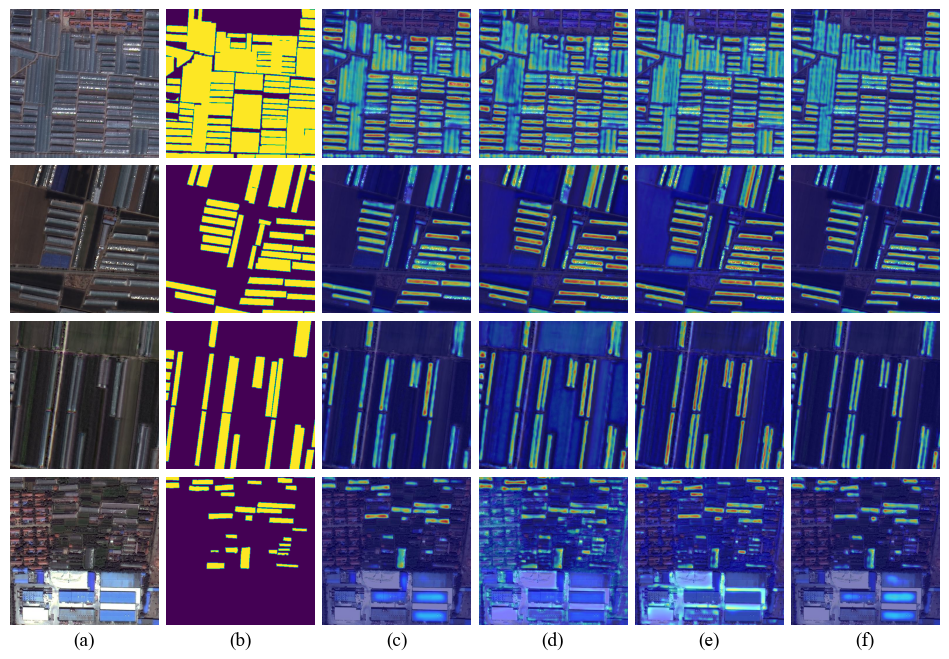

In [15]:
# 
filefolder_names = ["422", 
                    "768", 
                    "1851",
                    "2689", 
                    ]

img_names = ["ori",
             "label",
             "hrnet",
             "se",
             "cbam",
             "newsp"
            ]


col_num = len(img_names)
row_num = len(filefolder_names)

fig, axs = plt.subplots(row_num, col_num, figsize=(col_num*2,row_num*2))


# 去掉刻度
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])



for i in range(row_num):
    for j in range(col_num):

        filefolder_path = f"./img/{filefolder_names[i]}" 

        img_name = next((file_name for file_name in  os.listdir(filefolder_path)  if img_names[j] in file_name),None)
    
        image_path = os.path.join(f"./img/{filefolder_names[i]}" ,img_name)
        image = plt.imread(image_path)
        axs[i, j].imshow(image)

        # axs[i, j].axis('off') 

        if i == 3:
            label = f"({chr(97 + j)})"
            axs[i, j].text(0.5, -0.1, label, ha='center', va='center', transform=axs[i, j].transAxes, fontsize=14, fontproperties=FontProperties(fname="Times New Roman.ttf"))
            axs[i, j].axis('off')  # 关闭子图坐标轴

        else:
            axs[i, j].axis('off')  # 关闭子图坐标轴



# 调整子图之间的间距
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.savefig(r"./atten_compare.jpg", dpi=600, bbox_inches='tight', pad_inches = 0.0)